In [5]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [38]:
class HASH_FUNS_ORIGINAL():
    def __init__(self, data):
        '''
        Initialize raw data, max value(C), dimension(d), 
            number of points(N), and an array maintaining the cluster index of each point
        
        self.points_distances reflect the true distance of two points. The init value is inf.
        self.RP reflect whether two points is near or note. "near" means the true distance is less than r.
        self.latest_cluster reflect the cluster label of each point, the init value is the points index.
        self.total_number_of_cluster reflect the total number of cluster. NOTE: It is not the current number of clusters.
        '''
        try:
            self.data = data
            if not data.dtype == int:
                raise TypeError
            
            self.C = self.data.max()
            if self.data.min() < 0:
                raise ValueError
            
            self.d = len(self.data[0])
            self.N = len(self.data)


            self.points_distances = np.array([np.array([np.inf] * self.N)] *
                                             self.N)
            
            self.RP = np.array([np.array([False] * self.N)] * self.N)            
            self.latest_cluster = np.arange(self.N)            
            self.total_number_of_cluster = self.N            
            self.single_linkage_matrix = []
            self.iteration_times = 0
            
        except AttributeError:
            print("Data size should be larger than 1")
        except TypeError:
            print("Data should be integers.")
        except ValueError:
            print("Data should be positive.")

    def set_parameters(self, k, l, A=2, T=0):
        '''Set up number of sampled digits(k), number of hash functions(l),
            increasing rate(A), noise exclusion threshold(T), and range of cluster inclusion r'''
        try:
            self.k = k
            if k <= 0 or not isinstance(k, int):
                raise ValueError("k should be positive integer.")
            if k > self.C*self.d:
                raise ValueError("k should be smaller than", self.C*self.d)
            self.l = l
            if l <= 0 or not isinstance(l, int):
                raise ValueError("l should be a positive integer.")
            self.A = A
            if A <= 0:
                raise ValueError("A should be positive.")
            self.T = T
            self.r = self.C*self.d/(2*self.k)*self.d**0.5
            if T > l:
                pass
            elif T <= l and T > 0:
                raise ValueError("T should be larger than l.")
            elif T < 0:
                raise ValueError("T should be non-negative.")
                
            self.create_BP()
        except ValueError:
            print('Some inputs are not right.')
            raise     
    
    def get_parameters(self):
        '''Show the current parameters'''
        print('l=',self.l,'\n')
        print('k=',self.k,'\n')
        print('r=',self.r,'\n')
        print('C=',self.C,'\n')
        print('d=',self.d,'\n')
        print('N=',self.N,'\n')
        print('A=',self.A,'\n')
        print('T=',self.T,'\n')

    def plot_raw_data(self):
        '''Plot the points on a 2d grid. Only 2d data allowed'''
        plt.scatter(self.data[:, 0], self.data[:, 1])        
        
    def fit_data(self):
        """
        Train data until all data merge into one cluster, during each phase, this function will update points distance
        and single linkage matrix.
        
        During each phase, the function will update r and k automatically, and the noise exclusion will 
        only be intergrated into the first phase.        
        """
        temp_1 = 0
        temp_2 = 0
        temp_3 = 0
    
        while len(self.latest_cluster[self.latest_cluster ==
                                      self.latest_cluster[0]]) != self.N:
            start = time.process_time()
            self.update_distance()
            end = time.process_time()
            temp_1+= end-start
            
            start = time.process_time()
            self.update_RP()
            end = time.process_time()
            temp_2+= end-start
            
            start = time.process_time()
            self.update_single_linkage_matrix()
            end = time.process_time()
            temp_3+= end-start
            
            self.r = self.r * self.A
            self.k = int(self.C * self.d * np.sqrt(self.d) / (2 * self.r))
            self.iteration_times += 1
            
        #print("update_distance:",temp_1)
        #print("update_RP:", temp_2)
        #print("update_single_linkage_matrix:",temp_3)
        return self.single_linkage_matrix
    
    def update_distance(self):
        """
        This function will update distance in every phase.
        
        self.near_points reflect the number of points near the point in every bucket.
        
        self.hash_value function return a matrix, which shape is (l * N * k). It contains l hash tables.
        for each hash table, we calculate the bucket and for each bucket, we calculate the points distances.
        """
        temp_2 = 0
        temp_3 = 0
        
        self.near_points = np.zeros(self.N)
        for hash_table in self.hash_value():
            
            start = time.process_time()
            candidates = self.identify_candidates(hash_table)
            end = time.process_time()
            temp_2 += end-start
            
            start = time.process_time()
            for lis in candidates:
                self.judge_cluster_by_distance(lis)
            end = time.process_time()
            temp_3 += end-start
        #print('already update points distance')
        #print("identify_candidates",temp_2)
        #print("judge_cluster",temp_3)

    def update_RP(self):
        """
        self.RP identify each two points is near or not.
            if two points p q is near, then self.RP[p,q] is True.
        
        self.not_noise_points is only used in the first phase, which will be used to judge noise point.
            if one points p is not noise, then the value is True.     
            
        self.near_points reflect the near points of the point p in all bucket in all hash functions. 
        self.core_points reflect whether the near points of the point p is bigger than T.
        """
        
        temp = self.points_distances < self.r
        self.RP += temp     
        
        if self.iteration_times == 0:
            self.not_noise_points = np.array([False] * self.N)
            self.core_points = self.near_points > self.T
            self.not_noise_points += self.core_points

            for i in range(self.N):
                if self.core_points[i]:
                    self.not_noise_points += self.RP[i]
        else:
            self.not_noise_points = np.array([True]* self.N)
        #print(self.not_noise_points)

    def update_single_linkage_matrix(self):
        """
        The single linkage matrix has four columns. The first two columns are the cluster label, the third columns
            is the distance of two cluster, and the fourth columns is the number of points in the new merged cluster.
            
        In the first phase, we will only count the not noise points.
        """
        
        for i in range(self.N):
            if not self.not_noise_points[i]:
                continue
            for j in range(i + 1, self.N):
                ele = self.RP[i, j]
                if ele and self.latest_cluster[i] != self.latest_cluster[j]:
                    temp1 = self.latest_cluster[i]
                    temp2 = self.latest_cluster[j]

                    temp = self.update_latest_cluster(i, j)
                    row = [temp1, temp2, self.r, temp]
                    self.single_linkage_matrix.append(row)
                    

    def update_latest_cluster(self, i, j):
        """
        input: near points i, j
        ouput: the total number of cluster.
        
        For near points i,j, this functions first identify the two cluster of two points and relabel all points in this 
            two clusters into a new label, which means "merge" two cluster.
        """
        
        temp = self.total_number_of_cluster
        self.latest_cluster[self.latest_cluster ==
                            self.latest_cluster[i]] = temp
        self.latest_cluster[self.latest_cluster ==
                            self.latest_cluster[j]] = temp
        self.total_number_of_cluster += 1
        return len(self.latest_cluster[self.latest_cluster == temp])

    def create_BP(self):
        '''Create a binary table. Each row is a Cd-dimensional vector 
            transformed from the d-dimensional vector'''        
        self.r = self.C * self.d / (2 * self.k) * np.sqrt(self.d)
        self.BP = np.zeros((self.N, self.C * self.d), dtype='int')
        for i in range(self.N):
            for k in range(self.d):
                start_point = self.C * k
                number_of_one = self.data[i][k]
                self.BP[i][start_point:start_point + number_of_one] = 1
        #print("already create binary table")
        return self.BP

    def create_hash_table(self):
        '''Create a hashed table. Each row has k bits randomly chosen 
            from the Cd-dimensional vector. '''        
        choice_value = np.random.choice(np.arange(self.C*self.d), self.k, replace = False)
        hash_table = self.BP[:, choice_value]
        return hash_table

    def hash_value(self):
        """
        Return a matrix with shape (l * N * k). This matrix contains l hash table.
        """
        
        table = np.zeros((self.l, self.N, self.k), dtype='int')
        for i in range(self.l):
            table[i, :, :] = self.create_hash_table()
        #print("already create hash function")
        return table

    def identify_candidates(self, A):
        """
        input: one hash table
        output: buckets
        
        this function calculate the buckets in one hash table. For each point p, it put the points with same hash value
            into the buckets. 
        However,if another point belonging to the same cluster as p has already been saved in the very bucket, 
            p is not stored in it.
        """
        
        result = []
        hash_bucket = {}
        for i in range(self.N):
            target = tuple(A[i])
            if target not in hash_bucket:
                hash_bucket[target] = [i]
            else:
                same_cluster = False
                for j in hash_bucket[target]:
                    if self.latest_cluster[i] == self.latest_cluster[j]:
                        same_cluster = True
                        break
                if not same_cluster:
                    hash_bucket[target] += [i]
                
        for k in hash_bucket.keys():
            temp = hash_bucket[k]
            if sorted(temp) not in result:
                result.append(sorted(temp))
        return result
    
    def judge_cluster_by_distance(self, lis):
        """
        input: one bucket
        
        This function will update the points_distances in one bucket. 
        For points_distance < r, count points' near points' number.
        """
        N = len(lis)
        for i in range(N):
            for j in range(N):
                par_points = (lis[i], lis[j])
                if self.points_distances[par_points] == np.inf:
                    dis = np.linalg.norm(self.data[lis[i]] - self.data[lis[j]])
                    self.points_distances[par_points] = dis
                    self.points_distances[par_points[::-1]] = dis
                else:
                    dis = self.points_distances[par_points]
                if self.iteration_times == 0 and dis < self.r:
                    self.near_points[lis[i]] += 1

In [30]:
%%cython -a
import cython
import random
import time
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt

cdef class HASH_FUNS():
    
    cdef public int C,d,k,l,T,N,total_number_of_cluster,iteration_times
    cdef public double A,r
    cdef public double[:,:] points_distances
    cdef public long[:,:] data,RP,BP
    cdef public long[:] core_points,not_noise_points,latest_cluster, near_points
    cdef public list single_linkage_matrix
    
    
    def __cinit__(self, long[:,:]data):
        '''
        Initialize raw data, max value(C), dimension(d), 
            number of points(N), and an array maintaining the cluster index of each point
        
        self.points_distances reflect the true distance of two points. The init value is inf.
        self.RP reflect whether two points is near or note. "near" means the true distance is less than r.
        self.latest_cluster reflect the cluster label of each point, the init value is the points index.
        self.total_number_of_cluster reflect the total number of cluster. NOTE: It is not the current number of clusters.
        '''
        
        try:
            self.data = data
            
            self.C = np.max(self.data)
            if np.min(self.data) < 0:
                print("the minimum is", np.min(self.data))
                raise ValueError
            
            self.d = len(self.data[0])
            self.N = len(self.data)

            self.points_distances = np.array([np.array([np.inf] * self.N)] *
                                             self.N)
            self.RP = np.array([np.array([False] * self.N)] * self.N,dtype = int)            
            self.latest_cluster = np.arange(self.N,dtype = int)            
            self.total_number_of_cluster = self.N            
            self.single_linkage_matrix = []
            self.iteration_times = 0
            self.near_points = np.zeros(self.N,dtype = int)
            
        except TypeError:
            print("Data should be integers.")
        except ValueError:
            print("Data should be positive.")
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def set_parameters(self, int k, int l, double A=2, int T=0):
        '''Set up number of sampled digits(k), number of hash functions(l),
            increasing rate(A), noise exclusion threshold(T), and range of cluster inclusion r'''
        try:
            self.k = k
            if k <= 0 or not isinstance(k, int):
                raise ValueError("k should be positive integer.")
            if k > self.C*self.d:
                raise ValueError("k should be smaller than", self.C*self.d)
            self.l = l
            if l <= 0 or not isinstance(l, int):
                raise ValueError("l should be a positive integer.")
            self.A = A
            if A <= 0:
                raise ValueError("A should be positive.")
            self.T = T
            self.r = self.C*self.d/(2*self.k)*self.d**0.5
            if T > l:
                pass
            elif T <= l and T > 0:
                raise ValueError("T should be larger than l.")
            elif T < 0:
                raise ValueError("T should be non-negative.")
                
            self.create_BP()
        except ValueError:
            print('Some inputs are not right.')
            raise 
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def get_parameters(self):
        '''Show the current parameters'''
        print('l=',self.l,'\n')
        print('k=',self.k,'\n')
        print('r=',self.r,'\n')
        print('C=',self.C,'\n')
        print('d=',self.d,'\n')
        print('N=',self.N,'\n')
        print('A=',self.A,'\n')
        print('T=',self.T,'\n')
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def plot_raw_data(self):
        '''Plot the points on a 2d grid. Only 2d data allowed'''
        plt.scatter(self.data[:, 0], self.data[:, 1])
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def fit_data(self):
        """
        Train data until all data merge into one cluster, during each phase, this function will update points distance
        and single linkage matrix.
        
        During each phase, the function will update r and k automatically, and the noise exclusion will 
        only be intergrated into the first phase.        
        """
        cdef int counter = 0
        cdef int i
        while counter != self.N:
            self.update_distance()
            self.update_RP()
            self.update_single_linkage_matrix()
            self.r = self.r * self.A
            self.k = int(self.C * self.d * np.sqrt(self.d) / (2 * self.r))
            self.iteration_times += 1
            
            counter = 0
            for i in range(self.N):
                if self.latest_cluster[i] == self.latest_cluster[0]:
                    counter += 1
            
        return self.single_linkage_matrix
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def update_distance(self):
        """
        This function will update distance in every phase.
        
        self.near_points reflect the number of points near the point in every bucket.
        
        self.hash_value function return a matrix, which shape is (l * N * k). It contains l hash tables.
        for each hash table, we calculate the bucket and for each bucket, we calculate the points distances.
        """
        cdef list candidates
        cdef long[:,:] hash_table
        cdef int i
        cdef list lis
        self.near_points = np.zeros(self.N,dtype = int)
        for i in range(self.l):
            hash_table = self.create_hash_table()
            candidates = self.identify_candidates(hash_table)
            for lis in candidates:
                self.judge_cluster_by_distance(lis)
        
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def update_RP(self):
        """
        self.RP identify each two points is near or not.
            if two points p q is near, then self.RP[p,q] is True.
        
        self.not_noise_points is only used in the first phase, which will be used to judge noise point.
            if one points p is not noise, then the value is True.     
            
        self.near_points reflect the near points of the point p in all bucket in all hash functions. 
        self.core_points reflect whether the near points of the point p is bigger than T.
        """
        cdef int i,j
        
        for i in range(self.N):
            for j in range(self.N):
                self.RP[i,j] += (self.points_distances[i,j] < self.r)  
        if self.iteration_times == 0:
            self.core_points = np.empty(self.N,dtype = int)
            self.not_noise_points = np.array([False]* self.N,dtype = int)
            for i in range(self.N):
                self.core_points[i] = (self.near_points[i] > self.T)
                self.not_noise_points[i] += self.core_points[i]

                if self.core_points[i]:
                    for j in range(self.N):
                        self.not_noise_points[j] += self.RP[i,j]
        else:
            self.not_noise_points = np.array([True]* self.N,dtype = int)

    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def update_single_linkage_matrix(self):
        """
        The single linkage matrix has four columns. The first two columns are the cluster label, the third columns
            is the distance of two cluster, and the fourth columns is the number of points in the new merged cluster.
            
        In the first phase, we will only count the not noise points.
        """
        cdef int temp1,temp2,temp,ele
        cdef list row
        cdef int i,j
        
        for i in range(self.N):
            if not self.not_noise_points[i]:
                continue
            for j in range(i+1,self.N):
                ele = self.RP[i][j]
                if ele and self.latest_cluster[i] != self.latest_cluster[j]:
                    temp1 = self.latest_cluster[i]
                    temp2 = self.latest_cluster[j]
                    temp = self.update_latest_cluster(i, j)
                    row = [temp1, temp2, self.r, temp]
                    self.single_linkage_matrix.append(row)
                   # print('length: ', len(self.single_linkage_matrix))
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def update_latest_cluster(self, int i, int j):
        """
        input: near points i, j
        ouput: the total number of cluster.
        
        For near points i,j, this functions first identify the two cluster of two points and relabel all points in this 
            two clusters into a new label, which means "merge" two cluster.
        """
        cdef int k,counter = 0
        temp1 = self.latest_cluster[i]
        temp2 = self.latest_cluster[j]
        for k in range(self.N):
            if self.latest_cluster[k] == temp1 or self.latest_cluster[k] == temp2:
                self.latest_cluster[k] = self.total_number_of_cluster
                counter += 1
                    
        self.total_number_of_cluster += 1
        return counter
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def create_BP(self):
        '''Create a binary table. Each row is a Cd-dimensional vector 
            transformed from the d-dimensional vector'''  
        cdef int i,k
        self.r = self.C * self.d / (2 * self.k) * np.sqrt(self.d)
        self.BP = np.zeros((self.N, self.C * self.d), dtype='int')
        for i in range(self.N):
            for k in range(self.d):
                start_point = self.C * k
                number_of_one = self.data[i][k]
                self.BP[i][start_point:start_point + number_of_one] = 1
        #print("already create binary table")
        return self.BP
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def create_hash_table(self):
        '''Create a hashed table. Each row has k bits randomly chosen 
            from the Cd-dimensional vector. '''
        cdef int k,i,j
        cdef long[:,:] hash_table = np.empty([self.N,self.k],dtype = int)
        cdef list choice_value = random.sample(range(self.C*self.d),self.k)
        for k in range(self.N):
            for i,j in enumerate(choice_value):
                hash_table[k,i] = self.BP[k,j]
        return hash_table
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def identify_candidates(self, long[:,:] A):
        """
        input: one hash table
        output: buckets
        
        this function calculate the buckets in one hash table. For each point p, it put the points with same hash value
            into the buckets. 
        However,if another point belonging to the same cluster as p has already been saved in the very bucket, 
            p is not stored in it.
        """
        cdef i,j
        cdef list result = []
        cdef dict hash_bucket = {}
        cdef int N = A.shape[0]
        cdef int k = A.shape[1]
        cdef int same_cluster
        cdef tuple target
        for i in range(N):
            target = tuple(A[i])
            if target not in hash_bucket:
                hash_bucket[target] = [i]
            else:
                same_cluster = 0
                for j in hash_bucket[target]:
                    if self.latest_cluster[i] == self.latest_cluster[j]:
                        same_cluster = 1
                        break
                if same_cluster == 0:
                    hash_bucket[target] += [i]
        
        
        for x in hash_bucket.keys():
            
            temp = hash_bucket[x]
            
            if sorted(temp) not in result:
                result.append(sorted(temp))
            
        
        return result
    
    @cython.wraparound(False)
    @cython.boundscheck(False)
    def judge_cluster_by_distance(self, list lis):
        """
        input: one bucket
        
        This function will update the points_distances in one bucket. 
        For points_distance < r, count points' near points' number.
        """
        
        cdef int k,i,j
        cdef int N = len(lis)
        cdef int row_num, col_num
        cdef double dis
        for i in range(N):
            for j in range(N):
                row_num = lis[i]
                col_num = lis[j]
                if self.points_distances[row_num,col_num] == np.inf:
                    dis = 0.0

                    for k in range(self.d):
                        dis += (self.data[row_num,k]-self.data[col_num,k])**2
                    dis = dis**0.5
                    self.points_distances[row_num,col_num] = dis
                    self.points_distances[col_num,row_num] = dis
                else:
                    dis = self.points_distances[row_num,col_num]
                if self.iteration_times == 0 and dis < self.r:
                    self.near_points[row_num] += 1

In [15]:
import time
import sklearn
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt

In [16]:
data = sklearn.datasets.load_iris().data
data = data[:,:]*10 - data.min(axis=0)*10
data = np.array(data, dtype='int')

test = HASH_FUNS(data)
test.set_parameters(100,10,2,15)
pass


In [17]:
output = test.fit_data()

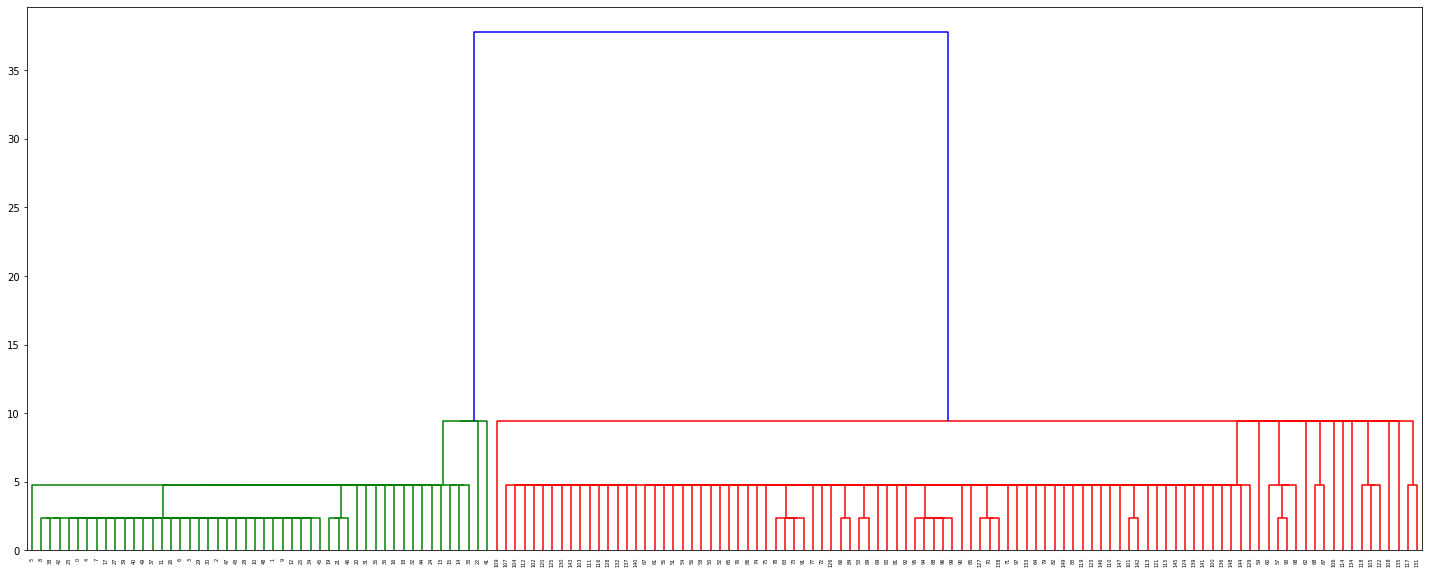

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(output)
plt.show()

In [35]:
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
X = np.array(X)
test2 = HASH_FUNS(X)
test2.set_parameters(4,10,2,11)


In [36]:
%time output = test2.fit_data()

CPU times: user 1.27 ms, sys: 6 µs, total: 1.27 ms
Wall time: 1.28 ms


In [45]:
%%timeit -n 100
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
X = np.array(X)
test2 = HASH_FUNS(X)
test2.set_parameters(4,10,2,11)
output = test2.fit_data()

784 µs ± 85.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
X = np.array(X)
test1 = HASH_FUNS_ORIGINAL(X)
test1.set_parameters(4,10,2,11)


In [42]:
%time output = test1.fit_data()

CPU times: user 3.77 ms, sys: 1.33 ms, total: 5.11 ms
Wall time: 4.77 ms


In [46]:
%%timeit
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
X = np.array(X)
test1 = HASH_FUNS_ORIGINAL(X)
test1.set_parameters(4,10,2,11)
output = test1.fit_data()

2.04 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


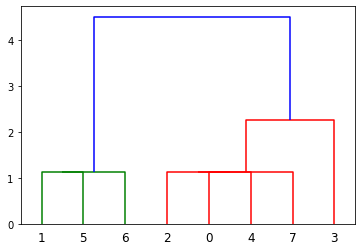

In [37]:
dendrogram(output)
pass

In [ ]:
import pandas as pd

In [ ]:
ls = np.zeros((150,150))
for i in range(150):
    for j in range(150):
        ls[i,j] = test.points_distances[i,j]
pd.DataFrame(ls)

# test

In [107]:
import time
data = sklearn.datasets.load_iris().data
data = data[:,:]*10 - data.min(axis=0)*10
data = np.array(data, dtype='int')

test = HASH_FUNS(data)
test.set_parameters(100,10,2,15)
pass

In [47]:
%%timeit -n 100
data = sklearn.datasets.load_iris().data
data = data[:,:]*10 - data.min(axis=0)*10
X = np.array(data, dtype='int')
test2 = HASH_FUNS(X)
test2.set_parameters(4,10,2,11)
output = test2.fit_data()

11.2 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
%%timeit -n 100
data = sklearn.datasets.load_iris().data
data = data[:,:]*10 - data.min(axis=0)*10
X = np.array(data, dtype='int')
test1 = HASH_FUNS_ORIGINAL(X)
test1.set_parameters(4,10,2,11)
output = test1.fit_data()

239 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test.get_parameters()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(output)
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(output)
plt.show()